<a href="https://colab.research.google.com/github/NamanJhawar-NMIMS/Classification-with-pyspark/blob/main/Assignment_Classification_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 199 kB 38.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=b4df436383248daa960ab3106d29ab124a1692bd181dc4fea88d2f7506d134ec
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=adac95a3c7ac6084da81261e3baeaba05d9710e28b75e6bcd5ed09b38cd983b3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
try:
  import pyspark
except:
  !pip install pyspark
  !pip install wget
  
from pyspark.sql import SparkSession
import wget
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.types import IntegerType,BooleanType,DateType

from pyspark.ml.feature import Imputer, StringIndexer,SQLTransformer,Binarizer,RegexTokenizer
from pyspark.ml.feature import IndexToString,OneHotEncoder,Normalizer,StandardScaler,Bucketizer,QuantileDiscretizer, VectorAssembler
from pyspark.ml.pipeline import Pipeline

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 60 kB/s 
     |████████████████████████████████| 199 kB 74.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=ddfc33098fc8b39f75e7e07c387514b21c5db89348bb40cc0d184c13dcaeb776
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=eef1211e99ee08e8d89b6b096766ed4586990259c8294377bfc641658dc05223
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
session=SparkSession.builder.appName("Classification").master("local").getOrCreate()

In [194]:
dataset=session.read.csv(wget.download("https://raw.githubusercontent.com/NamanJhawar-NMIMS/Classification-with-pyspark/main/watson_healthcare_attrition.csv"),header=True,inferSchema=True)

In [195]:
original_columns=list(dataset.columns)

In [196]:
dataset.show(5)

+----------+---+---------+-----------------+---------+----------+----------------+---------+--------------+-------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|EmployeeID|Age|Attrition|   BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|Shift|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrMan

In [173]:
dataset.count()

1676

In [197]:
print(f"Shape of Data:\n{dataset.count(),len(dataset.columns)}")

Shape of Data:
(1676, 35)


In [198]:
dataset.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (null

In [199]:
dataset.describe().show()

+-------+------------------+-----------------+---------+--------------+-----------------+----------+----------------+------------------+----------------+-------------+-----------------------+------+-----------------+------------------+------------------+---------+------------------+-------------+-----------------+-----------------+------------------+------+--------+------------------+------------------+------------------------+-------------+------------------+-----------------+---------------------+------------------+-----------------+------------------+-----------------------+--------------------+
|summary|        EmployeeID|              Age|Attrition|BusinessTravel|        DailyRate|Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|EnvironmentSatisfaction|Gender|       HourlyRate|    JobInvolvement|          JobLevel|  JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|      MonthlyRate|NumCompaniesWorked|Over18|OverTime| PercentSalaryHike| Perfor

In [200]:
print(f"Number of columns: {len(dataset.columns)}")

Number of columns: 35


In [201]:
df_dataset=pd.read_csv('watson_healthcare_attrition.csv')


In [202]:
df_temp=(df_dataset.isnull().sum()).to_frame()
df_temp[df_temp[0]>0]
columns_with_missing_values=list(df_temp[df_temp[0]>0].index)

In [203]:
dataset[columns_with_missing_values].printSchema()

# There are 3 integer variables with missing values
# There are 1 string variables with missing values

root
 |-- Age: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)



In [204]:
dataset.columns

['EmployeeID',
 'Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'Shift',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [205]:
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

TypeError: ignored

## Imputer

In [206]:
imputer = Imputer()
imputer.setInputCols(list(set(columns_with_missing_values)-set(['MaritalStatus'])))
imputer.setOutputCols([outcol+"_imputed" for outcol in list(set(columns_with_missing_values)-set(['MaritalStatus']))])
imputer.setStrategy("median")


Imputer_857a09dded78

## Impute Categorical Variables

This can be achived by first label encoding the categorical column and then using imputation.

In [207]:
stringIndexer_imputer=StringIndexer(inputCol='MaritalStatus',outputCol='MaritalStatus_indexed',stringOrderType="frequencyDesc",handleInvalid='keep')


## Pipeline

In [208]:
mypipeline_imputer=Pipeline(stages=[imputer,stringIndexer_imputer])
dataset=mypipeline_imputer.fit(dataset).transform(dataset)


In [209]:

"""As the MaritalStatus_Indexed column has null values and we have handled the Invalid cells, we need to remove that category which has
been created by the system to handle null values. In order to do that, we will convert the pyspark Dataframe into a pandas Dataframe and 
then replace the last category with null values"""

pd_df=dataset.toPandas()
pd_df.loc[pd_df[pd_df.MaritalStatus_indexed==3].index,"MaritalStatus_indexed"]=np.nan
dataset=session.createDataFrame(pd_df)

imputer_category=Imputer(inputCol="MaritalStatus_indexed",outputCol='MaritalStatus_indexed_imputed',strategy="mode")

mypipeline=Pipeline(stages=[imputer_category])
dataset=mypipeline.fit(dataset).transform(dataset)

# drop the columns that are not needed

dataset=dataset.drop("MaritalStatus_indexed")
dataset.show()

+----------+----+---------+-----------------+---------+----------+----------------+---------+--------------+-------------+-----------------------+------+----------+--------------+--------+--------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----------------+-----------------------------+-----------+-----------------------------+
|EmployeeID| Age|Attrition|   BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|       JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|Shift|TotalWorkingYears|Traini

In [210]:
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

TypeError: ignored

## 3. SQLTransformer

In [211]:
sqlTrans = SQLTransformer(statement="select Age, count(Age) from  __THIS__ group by Age order by age desc")
sql_age=sqlTrans.transform(dataset)
sql_age.show()

+----+----------+
| Age|count(Age)|
+----+----------+
| NaN|        12|
|60.0|         5|
|59.0|        10|
|58.0|        17|
|56.0|        15|
|55.0|        25|
|54.0|        20|
|53.0|        25|
|52.0|        21|
|51.0|        20|
|50.0|        33|
|49.0|        29|
|48.0|        23|
|47.0|        28|
|46.0|        38|
|45.0|        45|
|44.0|        36|
|43.0|        37|
|42.0|        52|
|41.0|        43|
+----+----------+
only showing top 20 rows



In [212]:
sql_age=sql_age.toPandas().dropna()

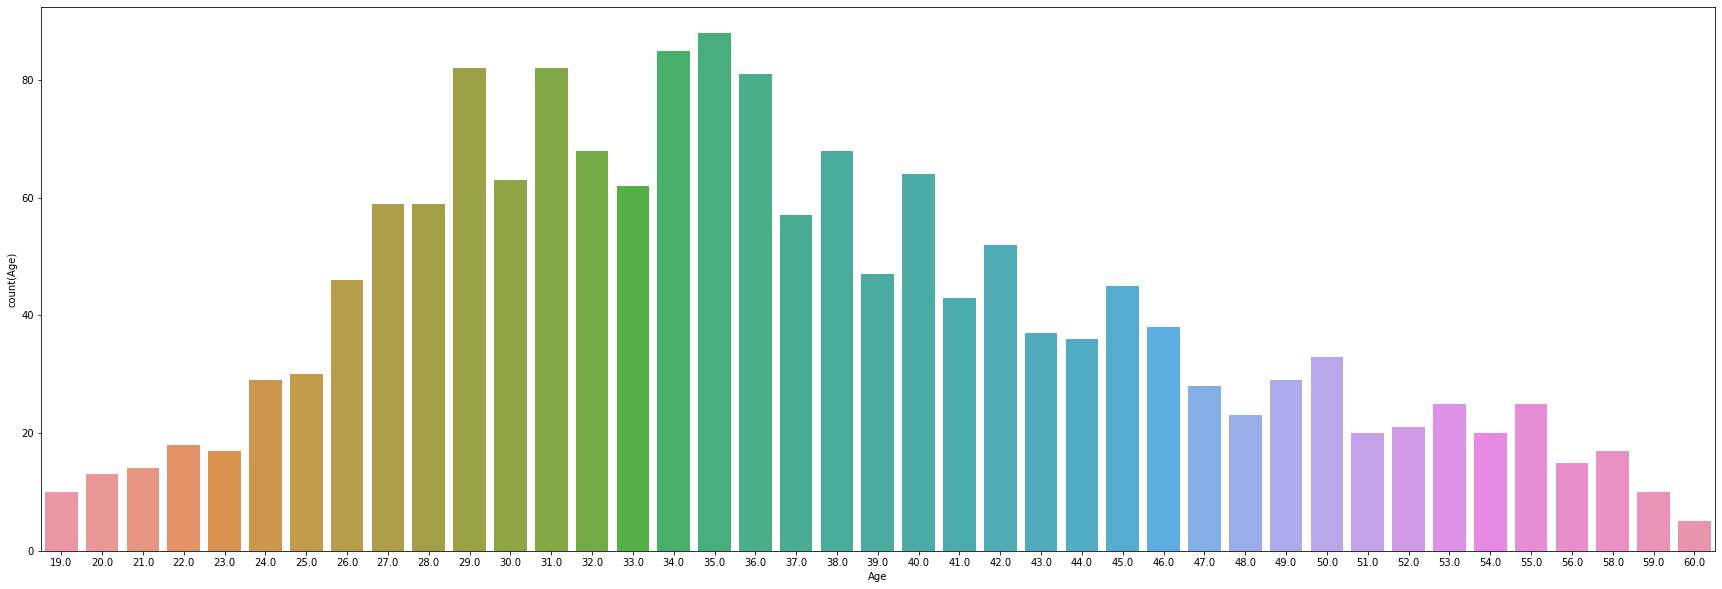

In [213]:
plt.figure(figsize=(30,10))
sns.barplot(x=sql_age.Age,y=sql_age['count(Age)']);

## 4. Binarizer

If the person has not been promoted in the last 3 years, then the value should be true (1) else false(0)

In [214]:
dataset=dataset.withColumn("YearsSinceLastPromotion",dataset.YearsSinceLastPromotion.cast("double"))

In [215]:
binarizer = Binarizer(threshold=3.0, inputCol="YearsSinceLastPromotion", outputCol="YearsSinceLastPromotionGt3")
dataset=binarizer.transform(dataset)

In [216]:
dataset.select('YearsSinceLastPromotion','YearsSinceLastPromotiongt3').show(10)

+-----------------------+--------------------------+
|YearsSinceLastPromotion|YearsSinceLastPromotiongt3|
+-----------------------+--------------------------+
|                    0.0|                       0.0|
|                    1.0|                       0.0|
|                    0.0|                       0.0|
|                    3.0|                       0.0|
|                    2.0|                       0.0|
|                    3.0|                       0.0|
|                    0.0|                       0.0|
|                    0.0|                       0.0|
|                    1.0|                       0.0|
|                    7.0|                       1.0|
+-----------------------+--------------------------+
only showing top 10 rows



## 5. Bucketizer

In [217]:
bucketizer = Bucketizer(splits=[-float("inf"), 2926.75, 4899,8380.75, float("inf")],inputCol="MonthlyIncome", outputCol="MonthlyIncome_buckets")
dataset=bucketizer.transform(dataset)

In [218]:
dataset.select("MonthlyIncome",'MonthlyIncome_buckets').groupBy('MonthlyIncome_buckets').sum().orderBy('sum(MonthlyIncome)').show()

+---------------------+------------------+--------------------------+
|MonthlyIncome_buckets|sum(MonthlyIncome)|sum(MonthlyIncome_buckets)|
+---------------------+------------------+--------------------------+
|                  0.0|            986805|                       0.0|
|                  1.0|           1660574|                     419.0|
|                  2.0|           2588943|                     838.0|
|                  3.0|           5685353|                    1257.0|
+---------------------+------------------+--------------------------+



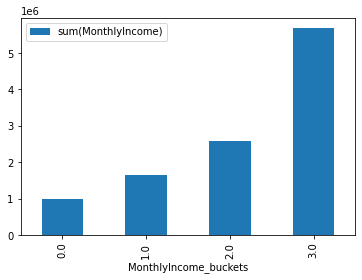

In [219]:
dataset.select("MonthlyIncome",'MonthlyIncome_buckets').groupBy('MonthlyIncome_buckets').sum().orderBy('sum(MonthlyIncome)').toPandas().plot.bar(x='MonthlyIncome_buckets',y='sum(MonthlyIncome)');

## 6. RegexTokenizer

In [220]:
regTokenize=RegexTokenizer(inputCol="DistanceFromHome",outputCol="DistanceFromHome_reg",pattern=" km")
dataset=regTokenize.transform(dataset)

# The regTokenizer returns a column with the datatype as Array, which contains the value in string format. We need to first extract the value from the Array and then typecast it into Interger.
dataset=dataset.withColumn("DistanceFromHome_reg",dataset.DistanceFromHome_reg[0])
dataset=dataset.withColumn("DistanceFromHome_reg",dataset.DistanceFromHome_reg.cast("int"))

dataset.printSchema()

root
 |-- EmployeeID: long (nullable = true)
 |-- Age: double (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: double (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: long (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: long (nullable = true)
 |-- EnvironmentSatisfaction: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: long (nullable = true)
 |-- JobInvolvement: long (nullable = true)
 |-- JobLevel: long (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: long (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: long (nullable = true)
 |-- MonthlyRate: long (nullable = true)
 |-- NumCompaniesWorked: long (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike

## 7. One hot encoder


In [221]:
""" 
In order to one hot encode all the categorical variables, we need to do the following steps
 1. Identify all the categorical Variables
 2. Check if they have any inherent Hierachy
 3. Apply StringIndexer to all the categorical variables
 4. OneHotEncode only those categorical variables that do not have any hierachy
"""
cat_col=[]
for col,data_type in dataset.dtypes:
  if data_type=='string':
    cat_col.append(col)

print(cat_col)

"""
 Out of the above columns, MaritalStatus has already been StringIndexed and now only needs to be One hot encoded.
 DistanceFromHome Column is not needed as we have already preprocessed it and converted it into a int column
 Attrition is the Dependent variable and hence will not be one hot encoded
 None of the other variables have a hierarchy and hence we are okay to onehotencode them
"""
cat_col.pop(cat_col.index('DistanceFromHome'))
cat_col.pop(cat_col.index('MaritalStatus'))
# Drop Over18 as this column has only 1 category and as such is not useful
cat_col.pop(cat_col.index('Over18'))

bulk_indexer=StringIndexer(inputCols=cat_col,outputCols=[x+"_indexed" for x in cat_col])

# Before one hot encode, make sure to drop the dependent variable and add the other Categorical variable
inputColumns=list(set(bulk_indexer.getOutputCols())-set(['Attrition']))
inputColumns.extend(['MaritalStatus_indexed_imputed', 'YearsSinceLastPromotionGt3', 'MonthlyIncome_buckets'])
oneHotEncoder=OneHotEncoder(inputCols=inputColumns,outputCols=[x+"_onehot" for x in inputColumns])

myPipeline_bulk=Pipeline(stages=[bulk_indexer,oneHotEncoder])
dataset=myPipeline_bulk.fit(dataset).transform(dataset)
dataset.show()

['Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
+----------+----+---------+-----------------+---------+----------+----------------+---------+--------------+-------------+-----------------------+------+----------+--------------+--------+--------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----------------+-----------------------------+-----------+-----------------------------+--------------------------+---------------------+--------------------+-----------------+----------------------+------------------+----------------------+--------------+---------------+----------------+-----------------------+----------------------+--------

## Dropping Unwanted Columns

In [222]:
print(f"Dropping the following Columns:\n{inputColumns}")
print(dataset.count(),len(dataset.columns))
dataset=dataset.drop(*inputColumns)
print(dataset.count(),len(dataset.columns))

Dropping the following Columns:
['OverTime_indexed', 'JobRole_indexed', 'Attrition_indexed', 'Department_indexed', 'Gender_indexed', 'EducationField_indexed', 'BusinessTravel_indexed', 'MaritalStatus_indexed_imputed', 'YearsSinceLastPromotionGt3', 'MonthlyIncome_buckets']
1676 59
1676 49


In [224]:
columnsToDropBasedOnPreprocessing=print(set(dataset.columns)-set(original_columns))
# Drop all the original columns from which we have either imputed/Indexed/OneHotEncoded from the above list


{'Age_imputed',
 'Attrition_indexed_onehot',
 'BusinessTravel_indexed_onehot',
 'DailyRate_imputed',
 'Department_indexed_onehot',
 'DistanceFromHome_reg',
 'EducationField_indexed_onehot',
 'Gender_indexed_onehot',
 'JobRole_indexed_onehot',
 'MaritalStatus_indexed_imputed_onehot',
 'MonthlyIncome_buckets_onehot',
 'OverTime_indexed_onehot',
 'TrainingTimesLastYear_imputed',
 'YearsSinceLastPromotionGt3_onehot'}

In [223]:
dataset.toPandas().to_csv("dataf.csv")

In [ ]:
dataset.createOrReplaceTempView("attrition_tb")

In [189]:
session.sql("select Age, count(Age) from attrition_tb group by Age order by age desc").show()

+----+----------+
| Age|count(Age)|
+----+----------+
| NaN|        12|
|60.0|         5|
|59.0|        10|
|58.0|        17|
|56.0|        15|
|55.0|        25|
|54.0|        20|
|53.0|        25|
|52.0|        21|
|51.0|        20|
|50.0|        33|
|49.0|        29|
|48.0|        23|
|47.0|        28|
|46.0|        38|
|45.0|        45|
|44.0|        36|
|43.0|        37|
|42.0|        52|
|41.0|        43|
+----+----------+
only showing top 20 rows



In [190]:
session.sql("select Department, count(Department) from attrition_tb group by Department order by count(Department) desc").show()

+----------+-----------------+
|Department|count(Department)|
+----------+-----------------+
| Maternity|              796|
|Cardiology|              531|
| Neurology|              349|
+----------+-----------------+

